###Exemplo retirado do livro "A First Course in the Finite Element Method" - Daryl Logan 4ª Edição - Capítulo 6 Exemplo 6.1

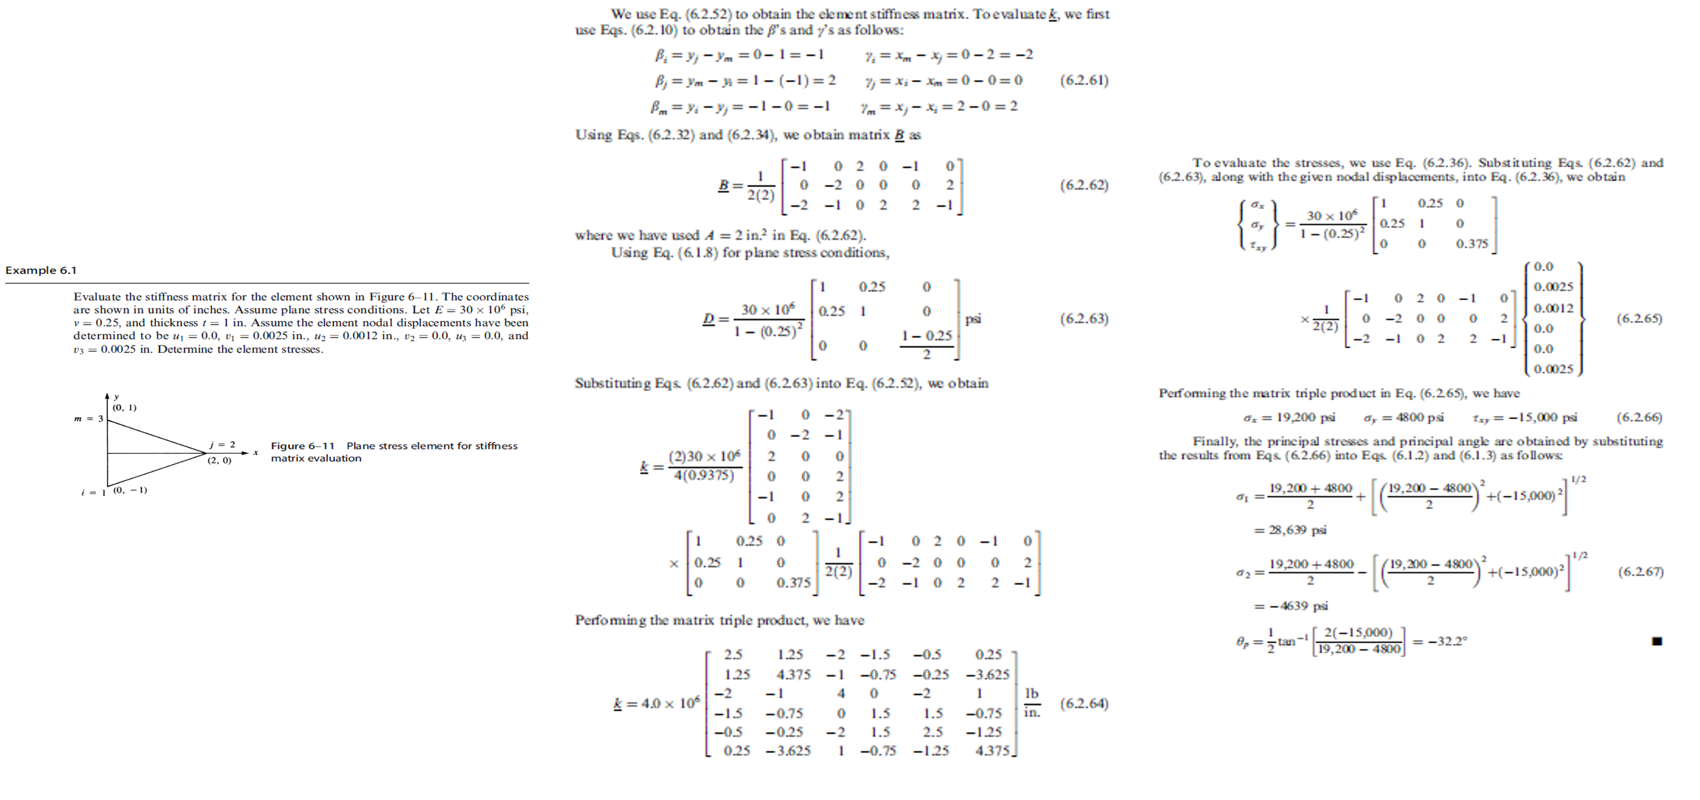

In [27]:
import requests
from PIL import Image
from io import BytesIO

file_id = '1w5uOwOdRXq_Aw-H1XMoyQVCc2XoWxGVM'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (1700, 800)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)
#https://drive.google.com/file/d/1w5uOwOdRXq_Aw-H1XMoyQVCc2XoWxGVM/view?usp=drive_link



##Dados de Entrada (Unidades Imperiais)

Definir todas as constantes do problema (propriedades do material e geometria do elemento)`

Unidade: Tudo está em unidades imperiais (polegadas e psi).

##Coeficientes e Geometria

Calcular a área (A) e os coeficientes geométricos ($β_i$,$γ_i$) que definem as derivadas da função de forma (shape function).

##Montagem da Matriz B (Deformação-Deslocamento)

A matriz $[B]$ relaciona os deslocamentos nodais (${δ}$) com as deformações no interior do elemento (${ε}$).

$${ε}=[B]{δ}$$

Detalhe: As linhas de $[B]$ correspondem a:

$ϵ_x​=∂u/∂x$ (depende dos $β's$)

$ϵ_y​=∂v/∂y$ (depende dos $γ's$)

$γ_xy​=∂u/∂y+∂v/∂x$ (depende da combinação)

##Matriz Constitutiva $[D]$ (Elasticidade)

A matriz $[D]$ (Matriz de Elasticidade ou Constitutiva) relaciona as deformações com as tensões, seguindo a Lei de Hooke para o Estado Plano de Tensões.

$${σ}=[D]{ε}$$

Fórmula: Os termos são derivados de:

$$σ_x = \frac{E}{1−ν^2}​(ϵ_x​+ν_{ϵy}​)$$

##Cálculo das tensões do elemento

Multiplicar $[B]×{δ}$ para encontrar as deformações ($ϵ_x$, $ϵ_y$, $γ_{xy}$).

Multiplicar $[D]×{ε}$ para encontrar as tensões do elemento ($σ_x$ ,$σ_y$ ,$τ_{xy}$).

##Transformações: de tensão e conversões de unidade

Depois de encontrar as tensões no sistema de coordenadas $x−y$, aplicamos as fórmulas de transformação (Círculo de Mohr) para encontrar as tensões máximas e mínimas que o material realmente sente ($σ_1$ ,$σ_2$), e o ângulo $θ_p$ onde elas ocorrem.

In [21]:
import numpy as np
import math

# --- 1. Dados de Entrada(imperial) ---
E = 30.0e6  # psi
nu = 0.25
t = 1.0     # in
coords = {1: (0.0, -1.0), 2: (2.0, 0.0), 3: (0.0, 1.0)}
delta = np.array([0.0, 0.0025, 0.0012, 0.0, 0.0, 0.0025]) # in

x1, y1 = coords[1]; x2, y2 = coords[2]; x3, y3 = coords[3]

# --- 2. Coeficientes e Geometria (Conforme a convenção do livro) ---

# Coeficientes Beta d/dy, Gamma para d/dx
# Beta (relacionado ao x-strain):
beta1 = y2 - y3  # -1
beta2 = y3 - y1  # 2
beta3 = y1 - y2  # -1
# Gamma (relacionado ao y-strain):
gamma1 = x3 - x2 # -2
gamma2 = x1 - x3 # 0
gamma3 = x2 - x1 # 2

# Determinante J (2A)
det_J = x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2) # Deve ser 4.0
Area = 0.5 * det_J # Deve ser 2.0

# Matriz B (Deformação-Deslocamento)
B_components = np.array([
    [beta1, 0, beta2, 0, beta3, 0],
    [0, gamma1, 0, gamma2, 0, gamma3],
    [gamma1, beta1, gamma2, beta2, gamma3, beta3]
])
B = (1/det_J) * B_components
gamma1_book = 2
gamma2_book = 0
gamma3_book = -2

B_book = (1/det_J) * np.array([
    [beta1, 0, beta2, 0, beta3, 0],
    [0, gamma1_book, 0, gamma2_book, 0, gamma3_book],
    [gamma1_book, beta1, gamma2_book, beta2, gamma3_book, beta3]
])

# --- 3. Matriz Constitutiva [D] (Estado Plano de Tensões) ---
factor_D = E / (1 - nu**2) # ~32e6
D = factor_D * np.array([
    [1, nu, 0],
    [nu, 1, 0],
    [0, 0, (1 - nu) / 2] # (1-nu)/2 = 0.375
])

# --- 4. Tensões do Elemento ---
epsilon = B_book @ delta
sigma_psi = D @ epsilon

print("--- SOLUÇÃO ---")
print(" ")
print(f"Vetor de Deformação {{ε}} (adimensional):\n{epsilon}")
print(" ")
print(f"Vetor de Tensão {{σ}} (psi):\n{sigma_psi}")
print(" ")
print(f"σx: {sigma_psi[0]:.0f} psi")
print(f"σy: {sigma_psi[1]:.0f} psi")
print(f"τxy: {sigma_psi[2]:.0f} psi")

# --- 5. Tensões Principais e Conversão Métrica ---
sigma_x = sigma_psi[0]
sigma_y = sigma_psi[1]
tau_xy = sigma_psi[2]

sigma_avg = (sigma_x + sigma_y) / 2
R = np.sqrt(((sigma_x - sigma_y) / 2)**2 + tau_xy**2)

sigma_1 = sigma_avg + R
sigma_2 = sigma_avg - R

# Ângulo Principal
two_theta_p_rad = math.atan2(2 * tau_xy, sigma_x - sigma_y)
theta_p_deg = np.rad2deg(two_theta_p_rad) / 2

# Fator de conversão: 1 psi = 6.89476 x 10^-3 MPa
PSI_TO_MPA = 6.89476e-3

print("\n--- Transformação de Tensão ---")
print(" ")
print(f"Tensão Principal Máxima (σ1): {sigma_1:.0f} psi | {sigma_1 * PSI_TO_MPA:.2f} MPa")
print(f"Tensão Principal Mínima (σ2): {sigma_2:.0f} psi | {sigma_2 * PSI_TO_MPA:.2f} MPa")
print(f"Ângulo Principal (θp): {theta_p_deg:.2f}°")

--- SOLUÇÃO ---
 
Vetor de Deformação {ε} (adimensional):
[ 0.0006   0.      -0.00125]
 
Vetor de Tensão {σ} (psi):
[ 19200.   4800. -15000.]
 
σx: 19200 psi
σy: 4800 psi
τxy: -15000 psi

--- Transformação de Tensão ---
 
Tensão Principal Máxima (σ1): 28639 psi | 197.46 MPa
Tensão Principal Mínima (σ2): -4639 psi | -31.98 MPa
Ângulo Principal (θp): -32.18°
